In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-03-01 23:52:44.758235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 23:52:44.947010: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 23:52:45.616313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


2023-03-01 23:52:47.255177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 23:52:48.159744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6


In [2]:
from local_utils import *

In [3]:
import pandas as pd
df_params = pd.read_pickle("../../bacterialcolony_dataset3/turing_df_circuit2_variant1_1000000parametersets.pkl")

In [4]:
df_params.head()

,DA,DB,bA,bB,bC,bD,bE,bF,VA,VB,...,nfe,nee,neb,nce,ss_n,ss_list,ss_class,system_class,maxeig,complex_dispersion
404,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,615.268976,73.210081,...,4.0,4.0,4.0,1.0,2.0,"[0.1997, 0.039, 10.9848, 104.771, 244.7529, 3....",stable spiral,turing I oscillatory,0.004898+0.036487j,True
2726,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,228.017071,94.502643,...,4.0,4.0,4.0,1.0,2.0,"[83.3645, 0.276, 12736.8586, 66.0485, 579.5646...",stable spiral,turing I oscillatory,0.000114+0.002647j,True
3508,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,23.538028,320.885489,...,4.0,4.0,4.0,1.0,3.0,"[6.9465, 0.1825, 57.5198, 3.3825, 131.0374, 1....",stable spiral,turing I oscillatory,0.001639+0.132134j,True
7516,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,16.205693,83.166774,...,4.0,4.0,4.0,1.0,1.0,"[1.7525, 0.2247, 908.552, 10.6864, 225.1614, 2...",stable spiral,turing I oscillatory,0.000652+0.003066j,True
7883,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,85.164519,738.495294,...,4.0,4.0,4.0,1.0,2.0,"[2.8165, 0.0136, 82.5102, 2.7508, 154.2711, 3....",stable spiral,turing I oscillatory,0.001346+0.016362j,True


In [5]:
import pickle

with open('../../bacterialcolony_dataset3/2Dfinal_circuit2_variant1_bc1.7_ca_ID546780_L8_J160_T125_N2500.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [33]:
ID = 546780
L = 8
data = np.array(ds_1)[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T=1
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
dxdy = x_size*y_size/L**2
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]

x_slice = slice(65, 100, 1)
y_slice = slice(65, 100, 1)

#data = data[:, x_slice, y_slice, np.newaxis]
#x_size = data.shape[1]
#y_size = data.shape[2]
#T = 1#data.shape[3]



indices_sub = indices_all[:, x_slice, y_slice]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

In [34]:
df_params.loc[ID,:]

DA                                                                  1.0
DB                                                                0.001
bA                                                                 0.01
bB                                                                 0.01
bC                                                                 0.01
bD                                                                 0.01
bE                                                                 0.01
bF                                                                 0.01
VA                                                            46.733347
VB                                                           134.697819
VC                                                            53.677758
VD                                                            44.231763
VE                                                            943.26562
VF                                                           605

In [35]:
def create_dataset_multi_nodes(
    data,
    t_star,
    N,
    T,
    L,
    training_data_size,
    pde_data_size,    
    signal_to_noise=0,
    shuffle=True,
    derivatives=None,
    idx_data=None,
):
    x_size = data.shape[1]
    y_size = data.shape[2]
    x_domain = L * np.linspace(0, 1, x_size)
    y_domain = L * np.linspace(0, 1, y_size)

    X, Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
    XX = np.tile(X.flatten(), T)  # N x T
    YY = np.tile(Y.flatten(), T)  # N x T
    TT = np.repeat(t_star[-T:], N)  # T x N

    #UU = np.einsum("cijk->ckij", data[:, :, :, -T:])
    UU = np.einsum("cxyk->ckxy", data[:, :, :, -T:])
    UU = np.array([UU[i, :, :, :].flatten() for i in range(UU.shape[0])])  # c , N x T
    
    if derivatives is not None:
        dds = np.array([[np.einsum("ijk->kij", d[i, :, :, -T:]).flatten() for d in derivatives]
               for i in range(derivatives[0].shape[0])
              ])                  
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_u = (np.max(UU) - np.min(UU)) / 2.0
        sigma_u = signal_amp_u * signal_to_noise
    # Observed data
    if idx_data is None:
        if shuffle:
            idx_data = np.random.choice(N * T, training_data_size, replace=False)
        else:
            idx_data = list(range(training_data_size))
    # PDE colocations
    if shuffle:
        idx_pde = np.random.choice(N * T, pde_data_size, replace=False)
    else:
        idx_pde = list(range(pde_data_size))

    # Lower/Upper bounds
    lb, ub = lower_upper_bounds(np.c_[XX, YY, TT])
    if derivatives is not None:
        derivatives_lb_ub = [
            lower_upper_bounds(dd.T) for dd in dds
        ]        

    ret = {
        "obs_input": np.c_[XX[idx_data], YY[idx_data], TT[idx_data]],
        "obs_output": np.vstack([UU[i, idx_data] for i in range(UU.shape[0])]).T,
        "pde": np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]],
        "lb": lb,
        "ub": ub,
    }
    if derivatives is not None:
        ret = {
            **ret,
            **{
                "ders": dds[:, :, idx_data],
                "derivatives_lb_ub": derivatives_lb_ub,
            },
        }
    if signal_to_noise > 0:
        ret["obs_output"] += sigma_u * np.random.randn(len(idx_data))

    return ret

In [36]:
data.shape

(6, 160, 160, 1)

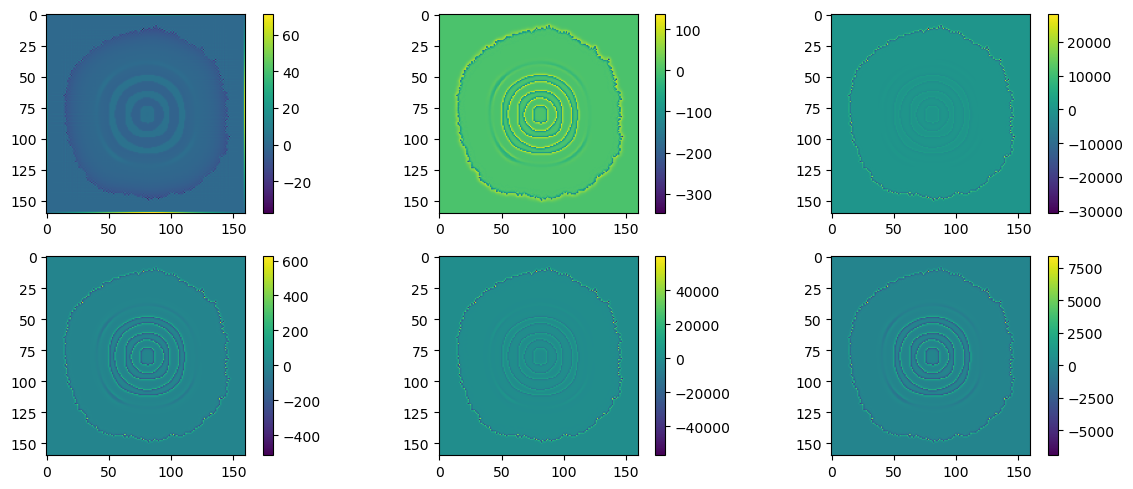

In [37]:
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

# c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
#                     for t in range(data.shape[3])]
#                     for c in range(data.shape[0])
#                    ])
# c_t = np.einsum("ctij -> cijt", c_t)

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow((c_xx[i,:, : , -1] + c_yy[i,:, : , -1]))
    plt.colorbar()
plt.tight_layout();plt.show()


In [38]:
c_xx.shape

(6, 160, 160, 1)

In [39]:
data.shape

(6, 160, 160, 1)

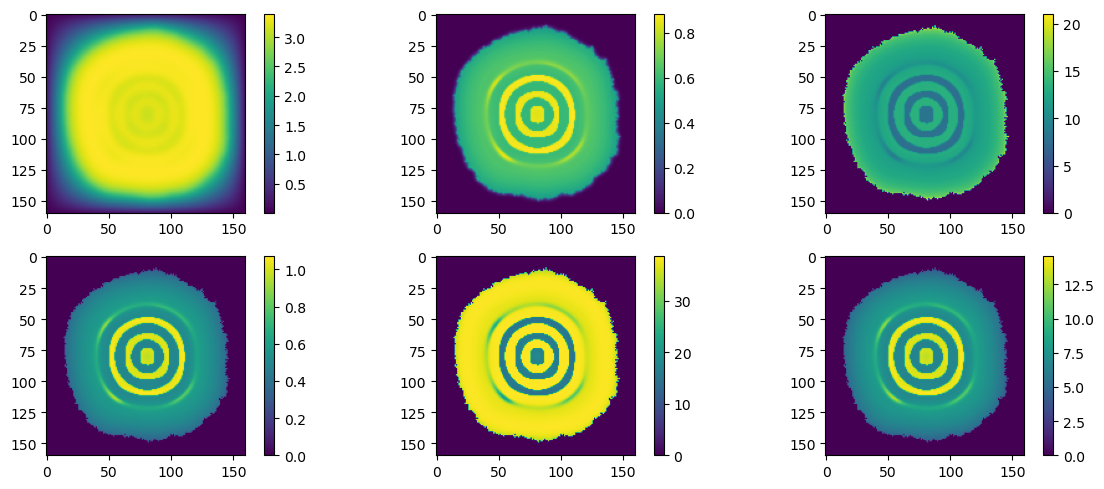

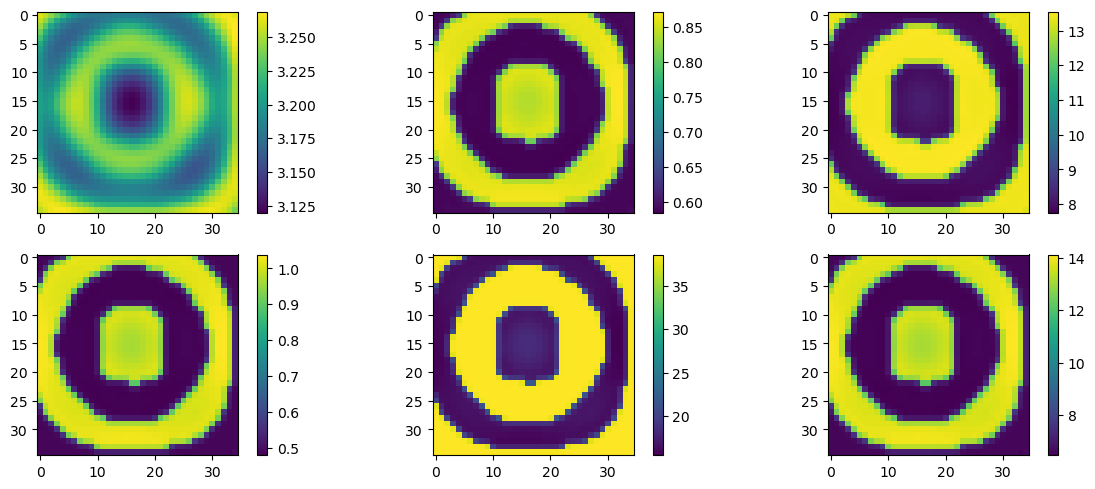

In [40]:
A = data[0, :, :, -1]
B = data[1, :, :, -1]
C = data[2, :, :, -1]
D = data[3, :, :, -1]
E = data[4, :, :, -1]
F = data[5, :, :, -1]

def activate(x, km, n=2):
    act = 1 / (1 + (km / (x + 1e-20)) ** (n))
    return act

def inhibit(x, km, n=2):
    inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
    return inh

params = df_params.loc[ID, :]
DA = params.DA    
DB = params.DB
bA = params.bA
bB = params.bB
bC = params.bC
bD = params.bD
bE = params.bE
bF = params.bF
VA = params.VA
VB = params.VB
VC = params.VC
VD = params.VD
VE = params.VE
VF = params.VF
Kab = params.Kab
Kbd = params.Kbd
Kce = params.Kce
Kda = params.Kda
Keb = params.Keb
Kee = params.Kee
Kfe = params.Kfe
muASV = params.muASV
muLVA = params.muLVA
nab = params.nab
nbd = params.nbd
nce = params.nce
nda = params.nda
nfe = params.nfe
neb = params.neb
nee = params.nee

A_rhs = DA * (c_xx[0, :, :, 0] + c_yy[0, :, :, 0])# - u_t
B_rhs = DB * (c_xx[1, :, :, 0] + c_yy[1, :, :, 0])# - v_t

f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
f_C =  - bC - VC * inhibit(D, Kda, nda) + muLVA * C
f_D =  - bD - VD * activate(B, Kbd, nbd) + muLVA * D
f_E =  - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
f_F =  - bF - VF * activate(B, Kbd, nbd) + muLVA * F

c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [41]:
c_xx.shape

(6, 160, 160, 1)

In [42]:
c_restricted = data[:, x_slice, y_slice, :].copy()
c_xx_restricted = c_xx[:, x_slice, y_slice, :].copy()
c_yy_restricted = c_yy[:, x_slice, y_slice, :].copy() 
c_t_restricted = c_t[:, x_slice, y_slice, :].copy()

    
model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}


dataset = create_dataset_multi_nodes(data, t_star, N, 1, L, **model_params)
lb = dataset['lb']#[0:2]
#Since there are just one time step, we set the lb of T equal to zero
lb[-1] = 0.0
ub = dataset['ub']#[0:2]
obs_X = np.float32(dataset['obs_input'])#[:, 0:2])
obs_Y = np.float32(dataset['obs_output'])
#pde_X = np.float32(dataset['pde'])
ders_xx = np.float32(dataset['ders'][:, 0, :])
ders_yy = np.float32(dataset['ders'][:, 1, :])
ders_t = np.float32(dataset['ders'][:, 2, :])

In [43]:
A.shape

(160, 160)

In [44]:
obs_X.shape

(1225, 3)

In [45]:
def gen_series():    
    
    for i in range(obs_X.shape[0]):        
        yield obs_X[i,:], obs_Y[i,:], ders_xx[:, i], ders_yy[:, i], ders_t[:, i]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((obs_X.shape[1],),(obs_Y.shape[1],),
                                                   (ders_xx.shape[0],),(ders_yy.shape[0],),
                                                   (ders_t.shape[0],)))

In [46]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        self.value = df_params.loc[ID,:][name]
        if value is None:
            self.value = df_params.loc[ID,:][name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 128, 128, 6],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=100, w6=100,w7=1,w8=1,
                DA_val=tf_param("DA"), DB_val=tf_param("DB"),
                bA_val=tf_param("bA"),bB_val=tf_param("bB"),bC_val=tf_param("bC"),
                bD_val=tf_param("bD"),bE_val=tf_param("bE"),bF_val=tf_param("bF"),
                VA_val=tf_param("VA"),VB_val=tf_param("VB"),VC_val=tf_param("VC"),
                VD_val=tf_param("VD"),VE_val=tf_param("VE"),VF_val=tf_param("VF"),
                Kab_val=tf_param("Kab"),Kbd_val=tf_param("Kbd"),Kce_val=tf_param("Kce"),
                Kda_val=tf_param("Kda"),Keb_val=tf_param("Keb"),Kee_val=tf_param("Kee"),
                Kfe_val=tf_param("Kfe"),muASV_val=tf_param("muASV"),muLVA_val=tf_param("muLVA"),
                nab_val=tf_param("nab"),nbd_val=tf_param("nbd"),nce_val=tf_param("nce"),
                nda_val=tf_param("nda"),nfe_val=tf_param("nfe"),neb_val=tf_param("neb"),
                nee_val=tf_param("nee")):    
    #lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
    #ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    DA = create_tf_var(DA_val)    
    DB = create_tf_var(DB_val)
    bA = create_tf_var(bA_val)#
    bB = create_tf_var(bB_val)#
    bC = create_tf_var(bC_val)#
    bD = create_tf_var(bD_val)#
    bE = create_tf_var(bE_val)#
    bF = create_tf_var(bF_val)#
    VA = create_tf_var(VA_val)
    VB = create_tf_var(VB_val)
    VC = create_tf_var(VC_val)
    VD = create_tf_var(VD_val)
    VE = create_tf_var(VE_val)
    VF = create_tf_var(VF_val)
    Kab = create_tf_var(Kab_val)
    Kbd = create_tf_var(Kbd_val)
    Kce = create_tf_var(Kce_val)
    Kda = create_tf_var(Kda_val)
    Keb = create_tf_var(Keb_val)
    Kee = create_tf_var(Kee_val)
    Kfe = create_tf_var(Kfe_val)
    muASV = create_tf_var(muASV_val)
    muLVA = create_tf_var(muLVA_val)
    nab = create_tf_var(nab_val)
    nbd = create_tf_var(nbd_val)
    nce = create_tf_var(nce_val)
    nda = create_tf_var(nda_val)
    nfe = create_tf_var(nfe_val)
    neb = create_tf_var(neb_val)
    nee = create_tf_var(nee_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")
    w5 = tf.Variable(w5,dtype=pinn.dtype,name="w5")
    w6 = tf.Variable(w6,dtype=pinn.dtype,name="w6")
    w7 = tf.Variable(w7,dtype=pinn.dtype,name="w7")
    w8 = tf.Variable(w8,dtype=pinn.dtype,name="w8")
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(DA_val, DA)
                    + as_tuple(DB_val, DB)
                    + as_tuple(bA_val, bA)
                    + as_tuple(bB_val, bB)
                    + as_tuple(bC_val, bC)
                    + as_tuple(bD_val, bD)
                    + as_tuple(bE_val, bE)
                    + as_tuple(bF_val, bF)
                    + as_tuple(VA_val, VA)
                    + as_tuple(VB_val, VB)
                    + as_tuple(VC_val, VC)
                    + as_tuple(VD_val, VD)
                    + as_tuple(VE_val, VE)
                    + as_tuple(VF_val, VF)
                    + as_tuple(Kab_val, Kab)
                    + as_tuple(Kbd_val, Kbd)
                    + as_tuple(Kce_val, Kce)
                    + as_tuple(Kda_val, Kda)
                    + as_tuple(Keb_val, Keb)
                    + as_tuple(Kee_val, Kee)
                    + as_tuple(Kfe_val, Kfe)
                    + as_tuple(muASV_val, muASV)
                    + as_tuple(muLVA_val, muLVA)
                    + as_tuple(nab_val, nab)
                    + as_tuple(nbd_val, nbd)
                    + as_tuple(nce_val, nce)
                    + as_tuple(nda_val, nda)
                    + as_tuple(nfe_val, nfe)
                    + as_tuple(neb_val, neb)
                    + as_tuple(nee_val, nee)
                   )

    @tf.function
    def train_step_inverse(elements):
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable


            with tf.GradientTape(persistent=True) as tape2:             
                tape2.watch(H)

                outputs = pinn.net(H)
                Ag = tf.squeeze(outputs[:, 0])
                Bg = tf.squeeze(outputs[:, 1])
#                 Cg = tf.squeeze(outputs[:, 2])
#                 Dg = tf.squeeze(outputs[:, 3])
#                 Eg = tf.squeeze(outputs[:, 4])
#                 Fg = tf.squeeze(outputs[:, 5])

                grad_A = tape2.gradient(Ag, H)
                A_x = grad_A[:, 0]
                A_y = grad_A[:, 1]

                grad_B = tape2.gradient(Bg, H)
                B_x = grad_B[:, 0]
                B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            A = tf.squeeze(elements[1][:, 0])
            B = tf.squeeze(elements[1][:, 1])
            C = tf.squeeze(elements[1][:, 2])
            D = tf.squeeze(elements[1][:, 3])
            E = tf.squeeze(elements[1][:, 4])
            F = tf.squeeze(elements[1][:, 5]) 

            act_A_xx = elements[2][:, 0]
            act_B_xx = elements[2][:, 1]
            act_A_yy = elements[3][:, 0]
            act_B_yy = elements[3][:, 1]

    #         act_A_t = elements[4][:, 0]
    #         act_B_t = elements[4][:, 1]
    #         act_C_t = elements[4][:, 2]
    #         act_D_t = elements[4][:, 3]
    #         act_E_t = elements[4][:, 4]
    #         act_F_t = elements[4][:, 5]            

            def activate(x, km, n=2):
                act = 1 / (1 + (km / (x + 1e-20)) ** (n))
                return act

            def inhibit(x, km, n=2):
                inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
                return inh

            A_rhs = DA * (A_xx + A_yy)# - u_t
            B_rhs = DB * (B_xx + B_yy)# - v_t

            f_A =  -bA -VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
            f_B =  -bB -VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
            f_C =  -bC -VC * inhibit(D, Kda, nda) + muLVA * C
            f_D =  -bD -VD * activate(B, Kbd, nbd) + muLVA * D
            f_E =  -bE -VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
            f_F =  -bF -VF * activate(B, Kbd, nbd) + muLVA * F
    #         f_C =  -act_C_t - bC - VC * inhibit(D, Kda, nda) + muLVA * C
    #         f_D =  -act_D_t - bD - VD * activate(B, Kbd, nbd) + muLVA * D
    #         f_E =  -act_E_t - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
    #         f_F =  -act_F_t - bF - VF * activate(B, Kbd, nbd) + muLVA * F

            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)
            l2_res_D = tf.reduce_sum(f_D**2)
            l2_res_E = tf.reduce_sum(f_E**2)
            l2_res_F = tf.reduce_sum(f_F**2)

            act_A_rhs = DA*(act_A_xx + act_A_yy) #- act_A_t
            act_B_rhs = DB*(act_B_xx + act_B_yy) #- act_B_t

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + w3*l2_res_C + w4*l2_res_D + 
                  w5*l2_res_E + w6*l2_res_F +  
                  w7*l2_res_A_rhs + w8*l2_res_B_rhs)
            #l2 = l2_res_A + l2_res_B  + l2_res_A_rhs + l2_res_B_rhs
            # l2 = l2_res_A_rhs + l2_res_B_rhs

        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, l2_res_C, l2_res_D, l2_res_E, l2_res_F,  
                l2_res_A_rhs, l2_res_B_rhs)
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C', 'l2_res_D', 'l2_res_E', 'l2_res_F',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5, w6, w7, w8)

In [47]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5, w6, w7, w8) = create_pinn(learning_rate=1e-2,
bA_val=tf_param("bA", 0, False),bB_val=tf_param("bB", 0, False),
VA_val=tf_param("VA", 0, False),VB_val=tf_param("VB", 0, False),
muASV_val=tf_param("muASV", 0, False),
w1=1, w2=1, w3=1, w4=1, w5=1, w6=1, w7=1, w8=1
)

(bA, bB,VA, VB, muASV) = params_trainable1

DA: 1.0
DB: 0.001
bA: 0
bB: 0
bC: 0.01
bD: 0.01
bE: 0.01
bF: 0.01
VA: 0
VB: 0
VC: 53.67775762072485
VD: 44.231762922444815
VE: 943.265620044018
VF: 605.0266911107649
Kab: 112.03598370729861
Kbd: 4.693803436565611
Kce: 0.9930030959145896
Kda: 0.2699281477606056
Keb: 45.269302324109745
Kee: 0.563496304565512
Kfe: 10.08286680374087
muASV: 0
muLVA: 1.4288264760159275
nab: 1.0
nbd: 2.0
nce: 1.0
nda: 1.0
nfe: 4.0
neb: 4.0
nee: 4.0


In [48]:
epochs=30000+1
params_est = np.zeros((epochs, 5))

def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = (bA.numpy(), bB.numpy(),
                             VA.numpy(), VB.numpy(),
                             muASV.numpy())

In [49]:
obs_X.shape

(1225, 3)

In [50]:
losses1 = tu.train(epochs=epochs,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 12228.031905833495
l2_res_A: 0.00056560, l2_res_B: 0.00000000, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 12223.62597656, l2_res_B_rhs: 3.99837947
bA:0: 0.010000207461416721, bB:0: 0.0, VA:0: 0.010000149719417095, VB:0: 0.0, muASV:0: 0.0
Time taken: 6.27s

Start of epoch 500
at epoch 500, total loss: 5816.909642564671
l2_res_A: 1962.89758301, l2_res_B: 1.82603979, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 3846.70141602, l2_res_B_rhs: 5.07761955
bA:0: 0.0, bB:0: 0.32654765248298645, VA:0: 5.503087043762207, VB:0: 5.679655075073242, muASV:0: 0.6267741322517395
Time taken: 20.45s

Start of epoch 1000
at epoch 1000, total loss: 4897.833538400548
l2_res_A: 1626.78613281, l2_res_B: 3.64751768, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 3260.57666016, l2_res_B_rhs: 6.41624355



Start of epoch 11000
at epoch 11000, total loss: 449.3729599589278
l2_res_A: 208.95521545, l2_res_B: 2.79578733, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 233.44485474, l2_res_B_rhs: 3.77011824
bA:0: 0.0, bB:0: 0.4301396906375885, VA:0: 44.77730178833008, VB:0: 110.81098175048828, muASV:0: 4.072283744812012
Time taken: 20.41s

Start of epoch 11500
at epoch 11500, total loss: 347.48114834965963
l2_res_A: 163.03639221, l2_res_B: 2.41935754, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 178.45404053, l2_res_B_rhs: 3.16437387
bA:0: 0.0, bB:0: 0.36703819036483765, VA:0: 45.026981353759766, VB:0: 114.28517150878906, muASV:0: 4.095583438873291
Time taken: 20.40s

Start of epoch 12000
at epoch 12000, total loss: 360.4189501875808
l2_res_A: 180.93914795, l2_res_B: 2.03307772, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 174


Start of epoch 21500
at epoch 21500, total loss: 127.38934640826483
l2_res_A: 60.03742981, l2_res_B: 0.90924311, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 65.09367371, l2_res_B_rhs: 0.94201559
bA:0: 0.0, bB:0: 0.03861164674162865, VA:0: 46.226905822753906, VB:0: 132.0159149169922, muASV:0: 4.201469898223877
Time taken: 20.55s

Start of epoch 22000
at epoch 22000, total loss: 118.00686763467093
l2_res_A: 58.29447937, l2_res_B: 0.91469538, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 57.43849564, l2_res_B_rhs: 0.95221305
bA:0: 0.0002741117205005139, bB:0: 0.03293824940919876, VA:0: 46.23310089111328, VB:0: 132.1439666748047, muASV:0: 4.20030403137207
Time taken: 20.51s

Start of epoch 22500
at epoch 22500, total loss: 92.58790414275427
l2_res_A: 44.99539948, l2_res_B: 0.81297880, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_re

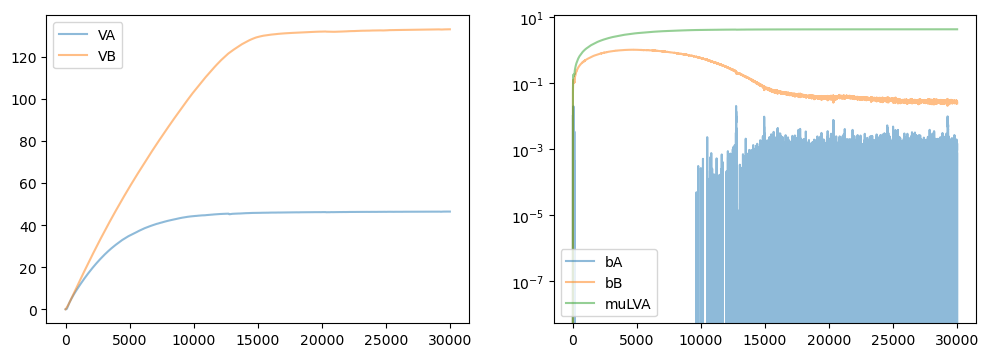

In [52]:
param_name = ["bA", "bB", "VA", "VB", "muLVA"]
plt.figure(figsize=(12,4));plt.subplot(121)
for i, n in enumerate(param_name):
    if params_est[-1,i] > 20:
        plt.plot(params_est[:,i], label=n, alpha=.5)
        
plt.legend();
plt.subplot(122)
for i, n in enumerate(param_name):
    if params_est[-1,i] <= 20:
        plt.plot(params_est[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

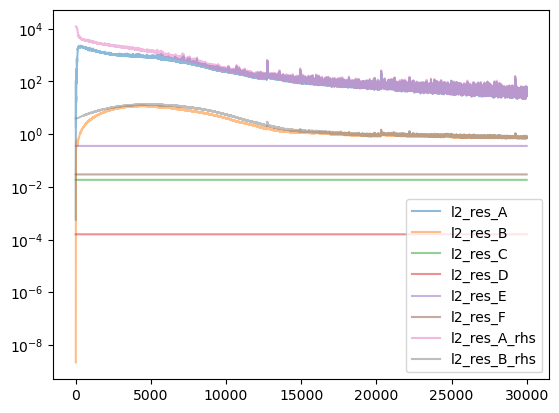

In [66]:
for i, n in enumerate(names):
    plt.plot(losses1[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

In [62]:
epochs2=10000+1
params_est2 = np.zeros((epochs2, 5))

def epoch_callback2(epoch, loss_samples, index):
    params_est2[epoch, : ] = (bA.numpy(), bB.numpy(),
                             VA.numpy(), VB.numpy(),
                             muASV.numpy())

In [63]:
optimizer1.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>

In [64]:
optimizer1.lr.assign(1e-3)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

In [65]:
losses2 = tu.train(epochs=epochs2,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 54.25300584973593
l2_res_A: 25.37532425, l2_res_B: 0.69547915, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 27.06133270, l2_res_B_rhs: 0.71388555
bA:0: 0.0009372556232847273, bB:0: 0.024261487647891045, VA:0: 46.44475555419922, VB:0: 133.1023712158203, muASV:0: 4.218308925628662
Time taken: 0.91s

Start of epoch 500
at epoch 500, total loss: 36.06923972310324
l2_res_A: 16.92279053, l2_res_B: 0.68773925, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 17.34663200, l2_res_B_rhs: 0.70509374
bA:0: 0.0, bB:0: 0.028255371376872063, VA:0: 46.49421310424805, VB:0: 133.14649963378906, muASV:0: 4.223528861999512
Time taken: 20.46s

Start of epoch 1000
at epoch 1000, total loss: 35.335511493103695
l2_res_A: 16.57477379, l2_res_B: 0.68781716, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 16.9

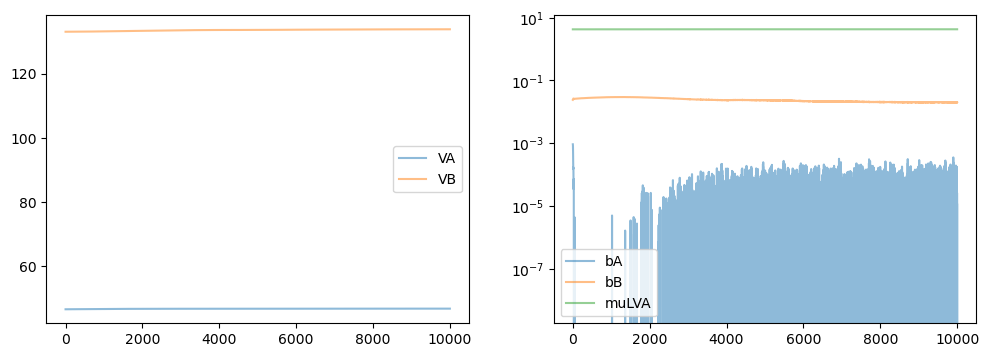

In [67]:
param_name = ["bA", "bB", "VA", "VB", "muLVA"]
plt.figure(figsize=(12,4));plt.subplot(121)
for i, n in enumerate(param_name):
    if params_est2[-1,i] > 20:
        plt.plot(params_est2[:,i], label=n, alpha=.5)
        
plt.legend();
plt.subplot(122)
for i, n in enumerate(param_name):
    if params_est2[-1,i] <= 20:
        plt.plot(params_est2[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

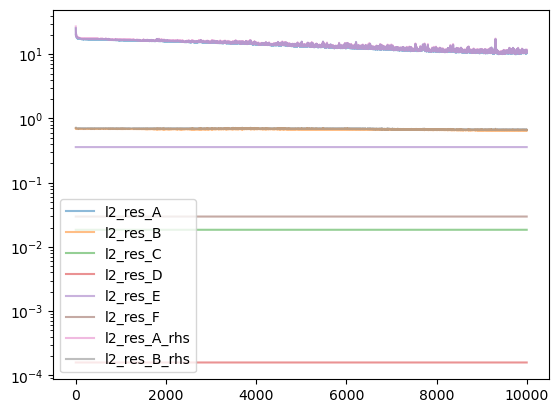

In [68]:
for i, n in enumerate(names):
    plt.plot(losses2[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

In [75]:
epochs3=50000+1
params_est3 = np.zeros((epochs3, 5))

def epoch_callback3(epoch, loss_samples, index):
    params_est3[epoch, : ] = (bA.numpy(), bB.numpy(),
                             VA.numpy(), VB.numpy(),
                             muASV.numpy())

In [76]:
losses3 = tu.train(epochs=epochs3,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback3,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 22.71850292624731
l2_res_A: 10.48018169, l2_res_B: 0.65485305, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 10.51283073, l2_res_B_rhs: 0.66365325
bA:0: 0.0, bB:0: 0.02017650194466114, VA:0: 46.644771575927734, VB:0: 133.8710479736328, muASV:0: 4.236518383026123
Time taken: 0.76s

Start of epoch 500
at epoch 500, total loss: 22.238711642639828
l2_res_A: 10.16765404, l2_res_B: 0.65944684, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 10.33687687, l2_res_B_rhs: 0.66774970
bA:0: 0.0, bB:0: 0.02017625980079174, VA:0: 46.64658737182617, VB:0: 133.87890625, muASV:0: 4.2367167472839355
Time taken: 20.45s

Start of epoch 1000
at epoch 1000, total loss: 24.719198095219326
l2_res_A: 11.39279938, l2_res_B: 0.65901625, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 11.59355545, l2_res_B_rhs: 


Start of epoch 10500
at epoch 10500, total loss: 18.28608803691168
l2_res_A: 8.26252270, l2_res_B: 0.64213634, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 8.32530594, l2_res_B_rhs: 0.64913887
bA:0: 0.0, bB:0: 0.01864120177924633, VA:0: 46.664791107177734, VB:0: 134.00010681152344, muASV:0: 4.2382965087890625
Time taken: 20.18s

Start of epoch 11000
at epoch 11000, total loss: 18.701984035389614
l2_res_A: 8.43997955, l2_res_B: 0.64132208, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 8.56567764, l2_res_B_rhs: 0.64802057
bA:0: 5.755278834840283e-05, bB:0: 0.01841249130666256, VA:0: 46.66499710083008, VB:0: 134.00294494628906, muASV:0: 4.238133430480957
Time taken: 20.33s

Start of epoch 11500
at epoch 11500, total loss: 19.19251929463644
l2_res_A: 8.63375187, l2_res_B: 0.64607781, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_


Start of epoch 21000
at epoch 21000, total loss: 16.24576376618643
l2_res_A: 7.24217176, l2_res_B: 0.62039733, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 7.34989119, l2_res_B_rhs: 0.62631929
bA:0: 2.2469232135335915e-05, bB:0: 0.01861759088933468, VA:0: 46.671897888183594, VB:0: 134.0253143310547, muASV:0: 4.238883972167969
Time taken: 20.10s

Start of epoch 21500
at epoch 21500, total loss: 15.448168503658962
l2_res_A: 6.88861752, l2_res_B: 0.61720383, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 6.91106224, l2_res_B_rhs: 0.62430072
bA:0: 0.0, bB:0: 0.018582243472337723, VA:0: 46.67131423950195, VB:0: 134.0265655517578, muASV:0: 4.238885402679443
Time taken: 20.19s

Start of epoch 22000
at epoch 22000, total loss: 15.349245774166775
l2_res_A: 6.80912209, l2_res_B: 0.61937326, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_


Start of epoch 31500
at epoch 31500, total loss: 14.635989057438564
l2_res_A: 6.48767281, l2_res_B: 0.60849524, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 6.51880121, l2_res_B_rhs: 0.61403561
bA:0: 0.0, bB:0: 0.018790239468216896, VA:0: 46.67776870727539, VB:0: 134.04307556152344, muASV:0: 4.239584922790527
Time taken: 20.07s

Start of epoch 32000
at epoch 32000, total loss: 15.038357781784725
l2_res_A: 6.68363190, l2_res_B: 0.60245091, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 6.73662329, l2_res_B_rhs: 0.60866749
bA:0: 1.684483686403837e-05, bB:0: 0.018485326319932938, VA:0: 46.67689895629883, VB:0: 134.04095458984375, muASV:0: 4.239365577697754
Time taken: 20.27s

Start of epoch 32500
at epoch 32500, total loss: 16.152003275768948
l2_res_A: 7.18015957, l2_res_B: 0.60745507, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_re


Start of epoch 42000
at epoch 42000, total loss: 13.11825298012991
l2_res_A: 5.73578548, l2_res_B: 0.58375371, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 5.80319071, l2_res_B_rhs: 0.58853889
bA:0: 0.0, bB:0: 0.018609683960676193, VA:0: 46.68229293823242, VB:0: 134.0671844482422, muASV:0: 4.239899158477783
Time taken: 20.19s

Start of epoch 42500
at epoch 42500, total loss: 13.672363984005642
l2_res_A: 6.00907278, l2_res_B: 0.57914698, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 6.09247541, l2_res_B_rhs: 0.58468461
bA:0: 0.0, bB:0: 0.018683098256587982, VA:0: 46.68318557739258, VB:0: 134.07275390625, muASV:0: 4.2400360107421875
Time taken: 20.24s

Start of epoch 43000
at epoch 43000, total loss: 13.162080275433254
l2_res_A: 5.71847630, l2_res_B: 0.57690293, l2_res_C: 0.01849662, l2_res_D: 0.00015886, l2_res_E: 0.35860729, l2_res_F: 0.02972142, l2_res_A_rhs: 5.87753820, l

In [ ]:
bA: 0.01, bB: 0.01, VA: 46.733347, VB: 134.697819, muASV 4.247714

In [69]:
@tf.function
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            Dg = tf.squeeze(outputs[:, 3])
            Eg = tf.squeeze(outputs[:, 4])
            Fg = tf.squeeze(outputs[:, 5])

            grad_A = tape2.gradient(Ag, inputs)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]
            A_t = grad_A[:, 2]

            grad_B = tape2.gradient(Bg, inputs)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]
            B_t = grad_B[:, 2]
            
#             grad_C = tape2.gradient(Cg, inputs)
#             C_t = grad_C[:, 2]
            
#             grad_D = tape2.gradient(Dg, inputs)
#             D_t = grad_D[:, 2]
            
#             grad_E = tape2.gradient(Eg, inputs)
#             E_t = grad_E[:, 2]
            
#             grad_F = tape2.gradient(Fg, inputs)
#             F_t = grad_F[:, 2]
            

        grad_A_x = tape.gradient(A_x, inputs)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, inputs)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, inputs)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, inputs)
        B_yy = grad_B_y[:, 1]
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg), 
            tf.squeeze(Dg), 
            tf.squeeze(Eg), 
            tf.squeeze(Fg))                               
#     return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
#             tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
#             tf.squeeze(Cg), tf.squeeze(C_t),
#             tf.squeeze(Dg), tf.squeeze(D_t),
#             tf.squeeze(Eg), tf.squeeze(E_t),
#             tf.squeeze(Fg), tf.squeeze(F_t))

def to(arr):
    return arr.numpy().reshape(block_x, block_y)

def plot_state(pinn):
        (A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn, obs_X)
        
        A_der = DA*( to(A_xx) + to(A_yy))
        B_der = DB*( to(B_xx) + to(B_yy))

        actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
        actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
        # X and Y are misoriented
        A_der = A_der
        B_der = B_der
        
        plot_n_im([to(A), c_restricted[0,:, : , -1], to(B), c_restricted[1,:, :  , -1]], 
          ["A", "Actual A", "B", "Actual B"],          
          figsize=(12, 3)); plt.tight_layout()

        A = c_restricted[0,:, : , -1]
        B = c_restricted[1,:, : , -1]

        
        
        plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
          ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
          figsize=(12, 3)); plt.tight_layout()

        plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
                  ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
                   ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
                   figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
        plot_n_im([A_der,  actual_A_der],
                  ["RHS A", "Actual RHS A"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([B_der,  actual_B_der],
                  ["RHS B", "Actual RHS B"],          
                  figsize=(12, 3)); plt.tight_layout()
        plt.show()

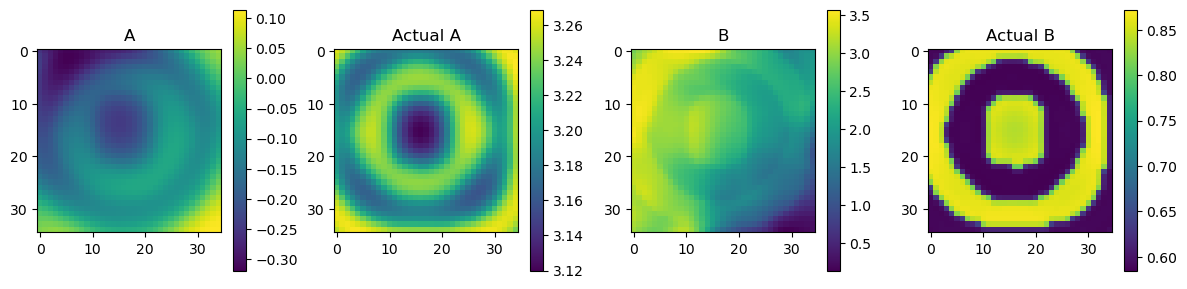

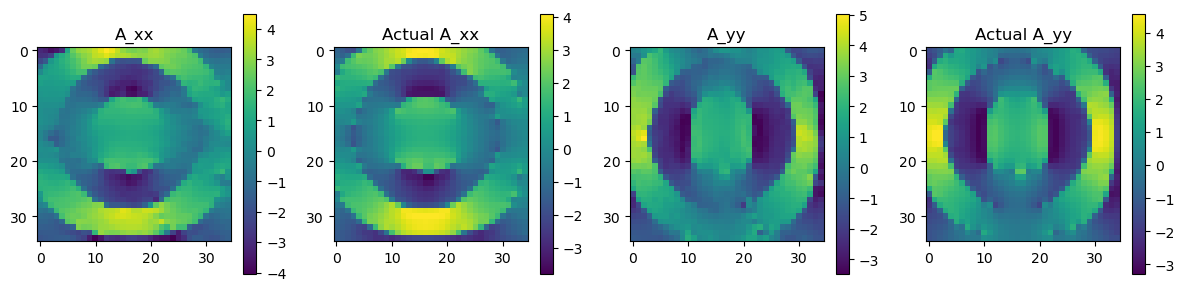

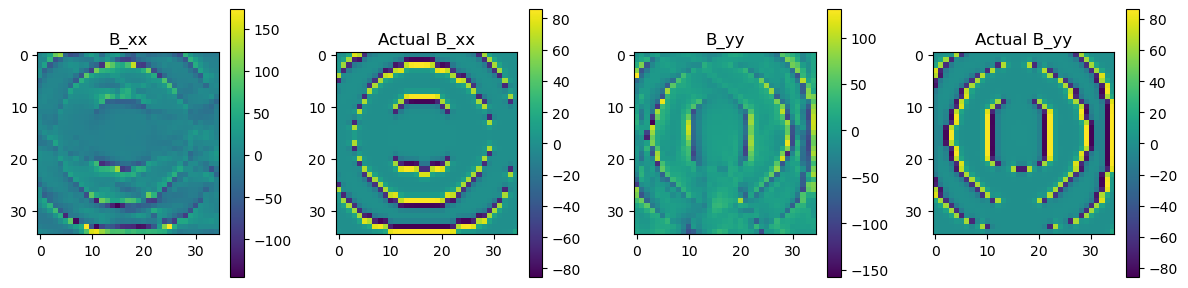

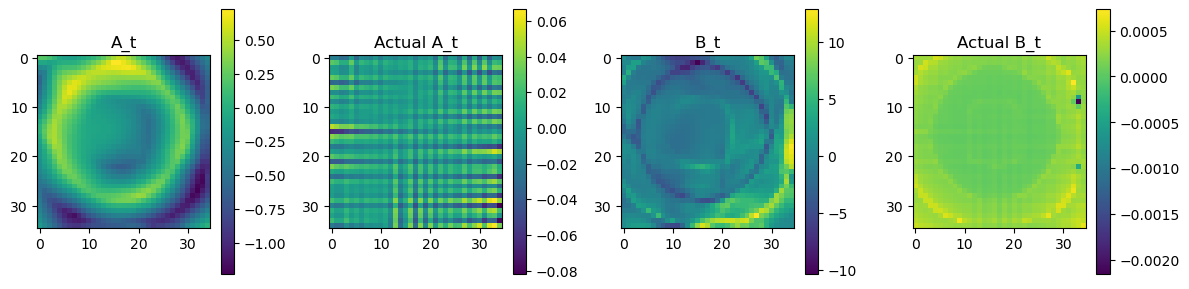

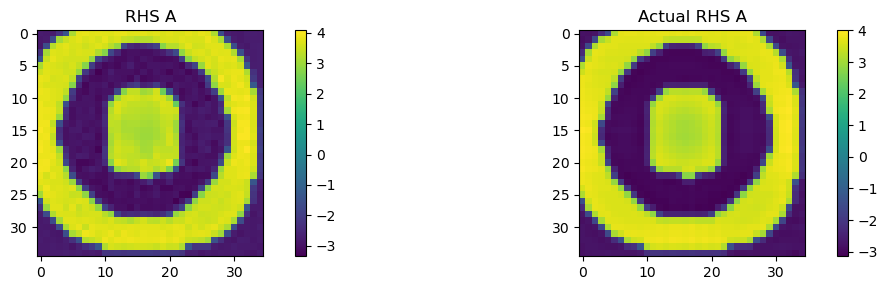

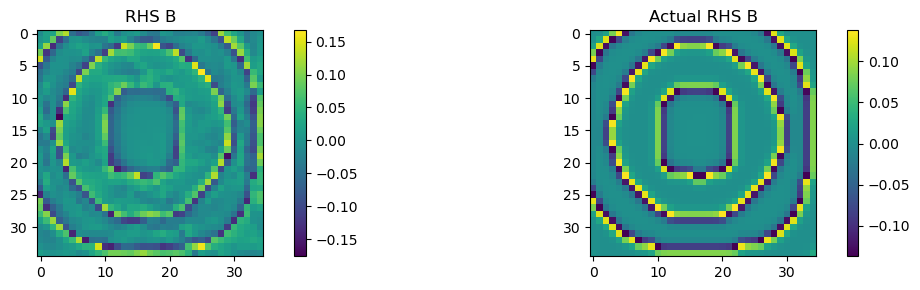

In [70]:
plot_state(pinn1)

In [71]:
(A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn1, obs_X)

In [72]:
u_t_act = c_t[0,x_slice, y_slice , -1]
v_t_act = c_t[1,x_slice, y_slice , -1]
print(np.sum(u_t_act**2))
print(np.sum(v_t_act**2))
print(np.sum(ders_t[0, :]**2))
print(np.sum(ders_t[1, :]**2))

0.49224496907994086
6.61899213916773e-05
0.492245
6.6189925e-05


In [73]:
A_der = DA*( to(A_xx) + to(A_yy))
B_der = DB*( to(B_xx) + to(B_yy))

actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]

In [74]:
print(np.sum((A_der-actual_A_der)**2))
print(np.sqrt(np.mean((A_der-actual_A_der)**2)))
print(np.mean(np.abs(A_der-actual_A_der)/np.abs(actual_A_der)))
print(np.sum((B_der-actual_B_der)**2))
print(np.sqrt(np.mean((B_der-actual_B_der)**2)))
print(np.mean(np.abs(B_der-actual_B_der)/np.abs(actual_B_der)))

10.512676833854952
0.09263788105968601
0.02298443880392776
0.6636526615438098
0.023275679898332523
57.12831224403344
